# Libs and Connect data

## Libs & Version check

In [5]:
import os, cv2, glob
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
print("Python:", os.sys.version)
print("OpenCV:", cv2.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("TensorFlow:", tf.__version__)
print("Scikit-learn:", sklearn.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Seaborn:", sns.__version__)

Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
OpenCV: 4.12.0
NumPy: 2.0.2
Pandas: 2.2.2
TensorFlow: 2.19.0
Scikit-learn: 1.6.1
Matplotlib: 3.10.0
Seaborn: 0.13.2


## Connect Google Drive

In [45]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
train_dir = "/content/drive/MyDrive/Motorola/VehicleOrientationClassificationSystem/datasets"
test_dir  = "/content/drive/MyDrive/Motorola/VehicleOrientationClassificationSystem/Test/AutoTest"
output_dir = '/content/drive/MyDrive/Motorola/VehicleOrientationClassificationSystem/Outputs'
model_dir = "/content/drive/MyDrive/Motorola/VehicleOrientationClassificationSystem/Models"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# Methodology

## Configuration

In [4]:
IMG_SIZE = (224, 224)
BATCH = 32
EPOCHS = 30
FINE_TUNE_EPOCHS = 25

## Train/Validation split

In [5]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset = "training",
    seed = 42,
    image_size = IMG_SIZE,
    batch_size = BATCH,
    label_mode = "int"
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = IMG_SIZE,
    batch_size = BATCH,
    label_mode = "int"
)

class_names = raw_train_ds.class_names
print("Classes:", class_names)

Found 2813 files belonging to 7 classes.
Using 2251 files for training.
Found 2813 files belonging to 7 classes.
Using 562 files for validation.
Classes: ['front', 'front_left', 'front_right', 'high_angle_view', 'rear', 'rear_left', 'rear_right']


## Data Augmentation

To improve model generalization and reduce overfitting, various augmentation
techniques are applied during training:

- **RandomFlip:** Horizontal and vertical flips  
- **RandomRotation:** Up to 30% rotation  
- **RandomZoom:** Random zoom up to 30%  
- **RandomContrast:** Adjust contrast by up to 30%  
- **RandomBrightness:** Adjust brightness by up to 30%  
- **RandomHeight / RandomWidth:** Random scaling of image dimensions


In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.3),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
])

## Data Pipeline Optimization

- Apply data augmentation to the training dataset.
- Use `tf.data.AUTOTUNE` to automatically tune the number of parallel calls for better performance.

In [7]:
autotune = tf.data.AUTOTUNE
train_ds = raw_train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=autotune)

## Data Preprocessing and Pipeline Optimization

- **Preprocessing:**  
  - Convert images to `float32` type  
  - Apply model-specific preprocessing (`preprocess_input`)  

- **Performance Optimization:**  
  - Use `tf.data.AUTOTUNE` for parallel mapping  
  - Apply `cache()` and `prefetch()` to speed up training

In [8]:
def preprocess(x, y):
    x = tf.cast(x, tf.float32)
    x = preprocess_input(x)
    return x, y

In [9]:
train_ds = train_ds.map(preprocess, num_parallel_calls=autotune)
val_ds = raw_val_ds.map(preprocess, num_parallel_calls=autotune)

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)

## Handling Class Imbalance

To address imbalanced classes in the dataset:

- Compute class weights
- These weights will be used during training to balance the loss contribution from each class

In [10]:
class_indices = np.arange(len(class_names))
y_train = np.concatenate([y for x, y in raw_train_ds], axis=0)
class_weights = compute_class_weight('balanced', classes=class_indices, y=y_train)
class_weights_dict = dict(zip(class_indices, class_weights))
print("Class weights:", class_weights_dict)

Class weights: {np.int64(0): np.float64(0.9627887082976904), np.int64(1): np.float64(0.8738354037267081), np.int64(2): np.float64(0.9032905296950241), np.int64(3): np.float64(1.516846361185984), np.int64(4): np.float64(1.0373271889400921), np.int64(5): np.float64(0.9267188143268835), np.int64(6): np.float64(0.9925044091710759)}


## Model Building – Transfer Learning

- **Base Model:** ResNet50 pretrained on ImageNet  
- **Configuration:**  
  - `include_top=False` → Remove the classification head  
  - `input_shape=(224, 224, 3)` → Match dataset image size  
  - `weights="imagenet"` → Use pretrained weights  
- **Trainable:** Set to `False` → Freeze base model during initial training to retain pretrained features

In [11]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable=False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Custom Classification Head

On top of the frozen ResNet50 base, a custom head is added for classification:

1. **GlobalAveragePooling2D:** Reduce spatial dimensions and convert feature maps into a vector  
2. **Dropout:** Regularization to prevent overfitting  
3. **Dense:** Fully-connected layer with 512 neurons for feature learning  
4. **Dropout:** Additional regularization  
5. **Dense:** Final output layer for multi-class classification

In [12]:
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(len(class_names), activation="softmax")(x)

## Model Compilation

- **Model Definition:** Combine the ResNet50 base and custom classification head into a complete model.  
- **Optimizer:** Adam with learning rate
- **Loss Function:** Sparse categorical crossentropy (since labels are integer encoded)  
- **Metrics:** Track accuracy during training and validation

In [13]:
model = models.Model(inputs=base_model.input, outputs=output)

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

## Training Callbacks

To improve training stability and performance, the following callbacks are used:

- **EarlyStopping:** Stop training if `val_loss` does not improve for 8 epochs, restoring the best weights  
- **ReduceLROnPlateau:** Reduce learning rate by factor 0.2 if `val_loss` plateaus for 4 epochs (minimum LR = 1e-6)  
- **ModelCheckpoint:** Save the best model (based on `val_accuracy`) to `vehicle_orientation_model.keras`

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)
checkpoint = ModelCheckpoint(os.path.join(model_dir, 'vehicle_orientation_model.keras'), monitor='val_accuracy', save_best_only=True, mode='max')

## Model Training

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 561s 8s/step - accuracy: 0.2297 - loss: 2.3990 - val_accuracy: 0.3665 - val_loss: 1.5811 - learning_rate: 0.0010
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.3941 - loss: 1.4971 - val_accuracy: 0.4520 - val_loss: 1.4068 - learning_rate: 0.0010
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.4741 - loss: 1.3322 - val_accuracy: 0.4609 - val_loss: 1.2858 - learning_rate: 0.0010
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.4940 - loss: 1.2633 - val_accuracy: 0.4466 - val_loss: 1.2850 - learning_rate: 0.0010
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.5075 - loss: 1.2038 - val_accuracy: 0.4875 - val_loss: 1.2001 - learning_rate: 0.0010
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.5238 - loss: 1.1278 - val_accuracy: 0.4964 - val_loss: 1.1765 - learning_rate: 0.0010
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.5593 - loss: 1.0715 - 

## Fine-tuning the Model
- **Unfreeze Base Model:** All layers are set trainable  
- **Freeze Early Layers:** Only the last 50 layers remain trainable (others are frozen to retain pretrained features)  
- **Re-compile Model:** With a lower learning rate (`1e-5`) to avoid catastrophic forgetting

In [17]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [19]:
fine_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINE_TUNE_EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 764s 11s/step - accuracy: 0.5811 - loss: 1.1122 - val_accuracy: 0.5302 - val_loss: 1.1559 - learning_rate: 1.0000e-05
Epoch 2/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.7018 - loss: 0.7185 - val_accuracy: 0.5338 - val_loss: 1.1301 - learning_rate: 1.0000e-05
Epoch 3/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.7513 - loss: 0.6152 - val_accuracy: 0.5427 - val_loss: 1.1154 - learning_rate: 1.0000e-05
Epoch 4/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - accuracy: 0.7744 - loss: 0.5619 - val_accuracy: 0.5391 - val_loss: 1.1057 - learning_rate: 1.0000e-05
Epoch 5/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.8209 - loss: 0.4633 - val_accuracy: 0.5516 - val_loss: 1.0899 - learning_rate: 1.0000e-05
Epoch 6/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step - accuracy: 0.8388 - loss: 0.4240 - val_accuracy: 0.5641 - val_loss: 1.0848 - learning_rate: 1.0000e-05
Epoch 7/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accu

## Model Save & Load

In [20]:
model.save(os.path.join(output_dir, 'vehicle_orientation_model.keras'))

In [21]:
model = tf.keras.models.load_model(os.path.join(model_dir, 'vehicle_orientation_model.keras'))

# Evaluate

In [47]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="int",
    shuffle=False
)
test_ds = test_ds.map(preprocess, num_parallel_calls=autotune).cache().prefetch(autotune)

Found 28 files belonging to 7 classes.


In [48]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


## Accuracy on Test set

In [49]:
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")

Test Accuracy: 75.00%


## Confusion Matrix

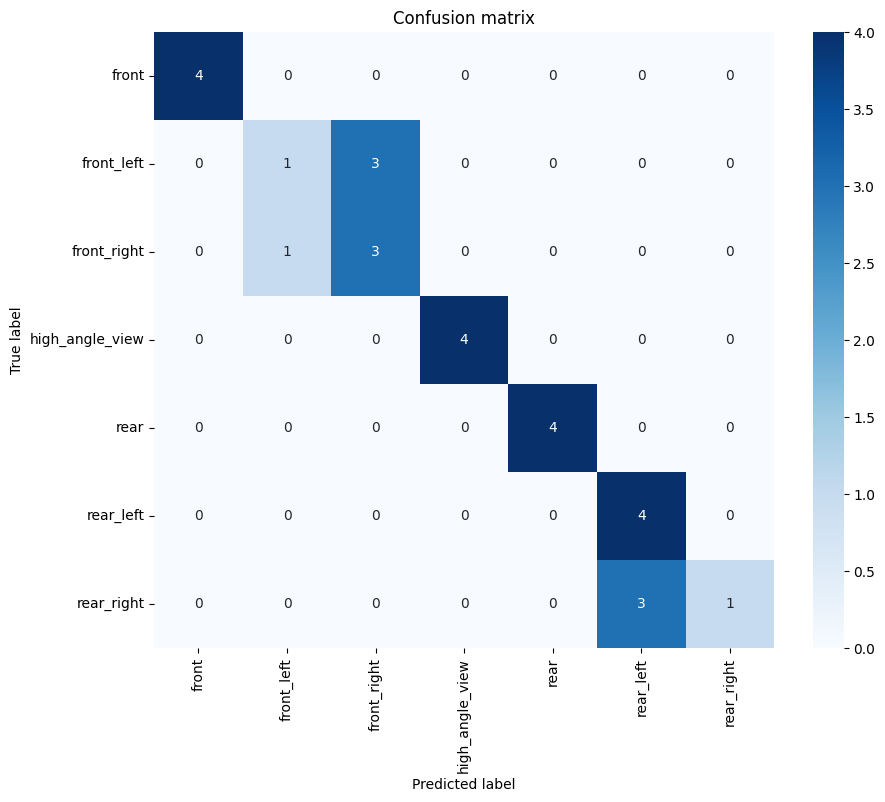

In [50]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

## Classification Report

In [51]:
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                  precision    recall  f1-score   support

          front       1.00      1.00      1.00         4
     front_left       0.50      0.25      0.33         4
    front_right       0.50      0.75      0.60         4
high_angle_view       1.00      1.00      1.00         4
           rear       1.00      1.00      1.00         4
      rear_left       0.57      1.00      0.73         4
     rear_right       1.00      0.25      0.40         4

       accuracy                           0.75        28
      macro avg       0.80      0.75      0.72        28
   weighted avg       0.80      0.75      0.72        28



# Test

## Auto test

In [52]:
test_images = []
test_labels = []
test_file_paths = []

In [53]:
for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    for img_path in glob.glob(os.path.join(class_path, '*.[jJ][pP][gG]')) + glob.glob(os.path.join(class_path, '*.[pP][nN][gG]')):
        img = load_img(img_path, target_size=IMG_SIZE)
        test_images.append(img)
        test_labels.append(class_names.index(class_name))
        test_file_paths.append(img_path)

In [54]:
test_images_array = np.array([img_to_array(img) for img in test_images])
test_images_preprocessed = preprocess_input(test_images_array)

In [55]:
predictions = model.predict(test_images_preprocessed)
predicted_labels = np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


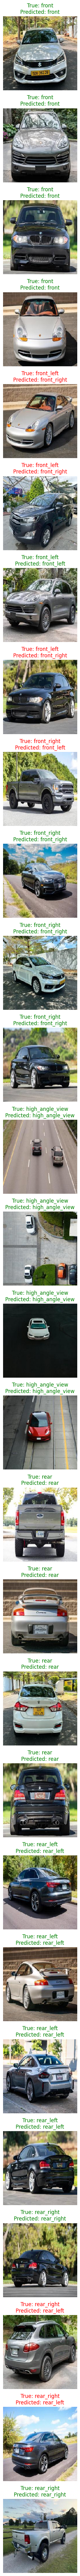

In [57]:
plt.figure(figsize=(15, len(test_images) * 3))
for i in range(len(test_images)):
    plt.subplot(len(test_images), 1, i + 1)
    plt.imshow(test_images[i])
    true_label = class_names[test_labels[i]]
    pred_label = class_names[predicted_labels[i]]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPredicted: {pred_label}', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Manual test

### Test 1

In [80]:
uploaded = files.upload()

Saving manual_1.jpg to manual_1.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
File: manual_1.jpg
Predicted Orientation: front
Confidence: 1.000


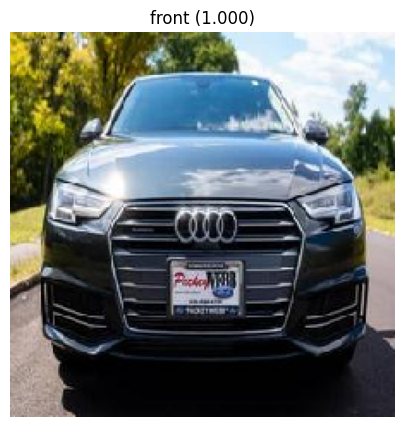

In [81]:
for fn in uploaded.keys():
    img = load_img(fn, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    pred_class = class_names[np.argmax(prediction[0])]
    confidence = np.max(prediction[0])

    print(f"File: {fn}")
    print(f"Predicted Orientation: {pred_class}")
    print(f"Confidence: {confidence:.3f}")

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"{pred_class} ({confidence:.3f})")
    plt.axis('off')
    plt.show()

### Test 2

In [82]:
uploaded = files.upload()

Saving manual_2.jpg to manual_2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
File: manual_2.jpg
Predicted Orientation: front_right
Confidence: 0.777


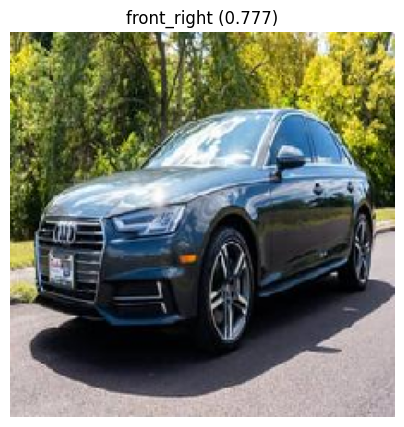

In [83]:
for fn in uploaded.keys():
    img = load_img(fn, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    pred_class = class_names[np.argmax(prediction[0])]
    confidence = np.max(prediction[0])

    print(f"File: {fn}")
    print(f"Predicted Orientation: {pred_class}")
    print(f"Confidence: {confidence:.3f}")

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"{pred_class} ({confidence:.3f})")
    plt.axis('off')
    plt.show()

### Test 3

In [84]:
uploaded = files.upload()

Saving manual_3.jpg to manual_3.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
File: manual_3.jpg
Predicted Orientation: rear_left
Confidence: 0.584


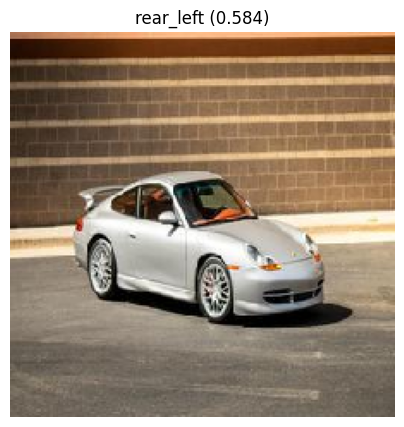

In [85]:
for fn in uploaded.keys():
    img = load_img(fn, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    pred_class = class_names[np.argmax(prediction[0])]
    confidence = np.max(prediction[0])

    print(f"File: {fn}")
    print(f"Predicted Orientation: {pred_class}")
    print(f"Confidence: {confidence:.3f}")

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"{pred_class} ({confidence:.3f})")
    plt.axis('off')
    plt.show()

### Test 4

In [86]:
uploaded = files.upload()

Saving manual_4.jpg to manual_4.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
File: manual_4.jpg
Predicted Orientation: front_right
Confidence: 0.997


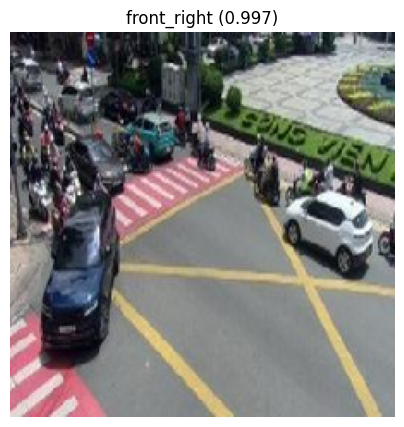

In [87]:
for fn in uploaded.keys():
    img = load_img(fn, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    pred_class = class_names[np.argmax(prediction[0])]
    confidence = np.max(prediction[0])

    print(f"File: {fn}")
    print(f"Predicted Orientation: {pred_class}")
    print(f"Confidence: {confidence:.3f}")

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"{pred_class} ({confidence:.3f})")
    plt.axis('off')
    plt.show()

### Test 5

In [88]:
uploaded = files.upload()

Saving manual_5.jpg to manual_5.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
File: manual_5.jpg
Predicted Orientation: rear
Confidence: 0.995


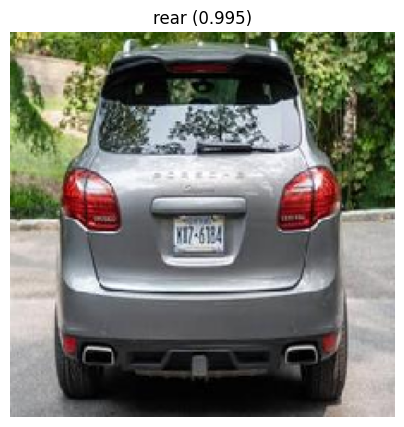

In [89]:
for fn in uploaded.keys():
    img = load_img(fn, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    pred_class = class_names[np.argmax(prediction[0])]
    confidence = np.max(prediction[0])

    print(f"File: {fn}")
    print(f"Predicted Orientation: {pred_class}")
    print(f"Confidence: {confidence:.3f}")

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"{pred_class} ({confidence:.3f})")
    plt.axis('off')
    plt.show()

### Test 6

In [90]:
uploaded = files.upload()

Saving manual_6.jpg to manual_6.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
File: manual_6.jpg
Predicted Orientation: rear_left
Confidence: 0.975


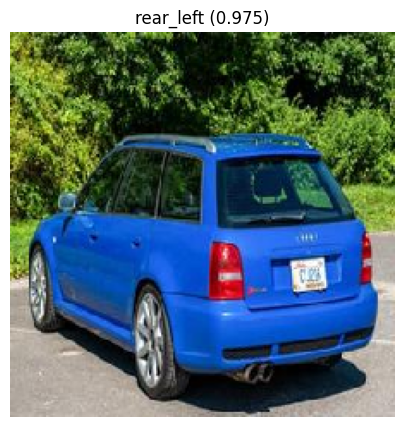

In [91]:
for fn in uploaded.keys():
    img = load_img(fn, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    pred_class = class_names[np.argmax(prediction[0])]
    confidence = np.max(prediction[0])

    print(f"File: {fn}")
    print(f"Predicted Orientation: {pred_class}")
    print(f"Confidence: {confidence:.3f}")

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"{pred_class} ({confidence:.3f})")
    plt.axis('off')
    plt.show()

### Test 7

In [92]:
uploaded = files.upload()

Saving manual_7.jpg to manual_7.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
File: manual_7.jpg
Predicted Orientation: rear_right
Confidence: 0.338


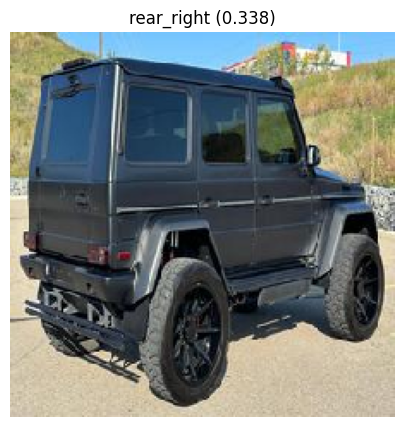

In [93]:
for fn in uploaded.keys():
    img = load_img(fn, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    pred_class = class_names[np.argmax(prediction[0])]
    confidence = np.max(prediction[0])

    print(f"File: {fn}")
    print(f"Predicted Orientation: {pred_class}")
    print(f"Confidence: {confidence:.3f}")

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"{pred_class} ({confidence:.3f})")
    plt.axis('off')
    plt.show()

# CSV export

In [94]:
data = []
for i in range(len(test_file_paths)):
    filename = os.path.basename(test_file_paths[i])
    pred_class = class_names[predicted_labels[i]]
    confidence = np.max(predictions[i])
    data.append({
        'filename': filename,
        'predicted_orientation_class': pred_class,
        'confidence': f"{confidence:.3f}"
    })

In [95]:
df = pd.DataFrame(data)
csv_path = os.path.join(output_dir, 'predictions.csv')
df.to_csv(csv_path, index=False)
print(f"CSV exported to {csv_path}")

CSV exported to /content/drive/MyDrive/Motorola/VehicleOrientationClassificationSystem/Outputs/predictions.csv
